In [1]:
import torch.nn as nn
import torch
import rawpy
import numpy as np
from torch.utils.data import DataLoader
from utils.datasets import LabeledDataset
from utils.preprocess import adjust_black_level

import torchvision.transforms as transforms

import ignite.distributed as idist
from ignite.engine import Engine, Events
from ignite.contrib.handlers import ProgressBar
from ignite.metrics import FID, InceptionScore, RunningAverage

from torch.profiler import profile, record_function, ProfilerActivity

from torchinfo import summary

torch.manual_seed(9706507364633013713)

In [2]:
root_dir = "dataset"
sony_csv_files = ["dataset/Sony_train_list.txt"]
fuji_csv_files =  ["dataset/Fuji_train_list.txt"]

batch_size = 8
input_size = 512

pre_crop_transform = transforms.Compose([
    transforms.ToTensor()
])

sony_dataset = LabeledDataset(root_dir, *sony_csv_files, training=True, save_gpu_memory=True, transform=pre_crop_transform)
sony_dataloader = idist.auto_dataloader(sony_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True, prefetch_factor=1)
print(sony_dataset[0][0].shape)
print(sony_dataset[0][1].shape)

Creating buffer for 233 images


2023-06-13 21:14:04,756 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<utils.datasets.Labe': 
	{'batch_size': 8, 'num_workers': 8, 'shuffle': True, 'drop_last': True, 'prefetch_factor': 1, 'pin_memory': True}


torch.Size([4, 512, 512])
torch.Size([3, 1024, 1024])


In [3]:
sony_dataset.prime_buffer()

In [4]:
# from unet.unet_model import UNet
from torch import optim 
from ignite.handlers.param_scheduler import LRScheduler

class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding)
        self.lrelu1_1 = nn.LeakyReLU(0.2, inplace=True)
        self.conv1_2 = nn.Conv2d(out_channel, out_channel, 3, padding=1)
        self.lrelu1_2 = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x = self.conv1_1(x)
        x = self.lrelu1_1(x)
        x = self.conv1_2(x)
        x = self.lrelu1_2(x)
        return x
    
class UpConcatBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(UpConcatBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channel, in_channel // 2, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(in_channel, out_channel)

    def forward(self, x1, x2):
        x1 = self.deconv(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = torch.nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv_block(x)

class UNet(nn.Module):
    def __init__(self, in_feat):
        super(UNet, self).__init__()
        
        self.down1 = ConvBlock(in_feat, 32) 
        self.pool1 = nn.MaxPool2d(2) # 512 -> 256
        self.down2 = ConvBlock(32, 64) 
        self.pool2 = nn.MaxPool2d(2) # 256 -> 128
        self.down3 = ConvBlock(64, 128) 
        self.pool3 = nn.MaxPool2d(2) # 128 -> 64
        self.down4 = ConvBlock(128, 256) 
        self.pool4 = nn.MaxPool2d(2) # 64 -> 32
        self.down5 = ConvBlock(256, 512)

        self.up5 = UpConcatBlock(512, 256) # 32 -> 64
        self.up4 = UpConcatBlock(256, 128) # 64 -> 128
        self.up3 = UpConcatBlock(128, 64) # 128 -> 256
        self.up2 = UpConcatBlock(64, 32) # 256 -> 512

        self.conv10 = nn.Conv2d(32, 12, 1) # 512 -> 512*2

    def forward(self, x):
        down1 = self.down1(x)
        down2 = self.down2(self.pool1(down1))
        down3 = self.down3(self.pool2(down2))
        down4 = self.down4(self.pool3(down3))
        down5 = self.down5(self.pool4(down4))

        up5 = self.up5(down5, down4)
        up4 = self.up4(up5, down3)
        up3 = self.up3(up4, down2)
        up2 = self.up2(up3, down1)

        out = self.conv10(up2)
        out = torch.nn.functional.pixel_shuffle(out, 2)
        # skip_z = {
        #     'up2': up2,
        #     'up3': up3,
        #     'up4': up4,
        #     'up5': up5,
        #     'down5': down5
        # }
        return out

class DownConcatBlock(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3, stride=1, padding=1):
        super(DownConcatBlock, self).__init__()
        self.conv_block = ConvBlock(in_channel+out_channel, out_channel, kernel_size, stride, padding)

    def forward(self, x1, x2):
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = torch.nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv_block(x)
    
class UUNet(nn.Module):
    def __init__(self):
        super(UUNet, self).__init__()

        self.down0 = ConvBlock(3, 16) # 1024 -> 512
        # self.down1 = DownConcatBlock(16, 32, 4, 2, 1) # 512 -> 256
        # self.down2 = DownConcatBlock(32, 64, 4, 2, 1) # 256 -> 128
        # self.down3 = DownConcatBlock(64, 128, 4, 2, 1) # 128 -> 64
        # self.down4 = DownConcatBlock(128, 256, 4, 2, 1) # 64 -> 32
        # self.down5 = DownConcatBlock(256, 512, 4, 2, 1)

        self.down1 = ConvBlock(16, 32, 4, 2, 1) # 512 -> 256
        self.down2 = ConvBlock(32, 64, 4, 2, 1) # 256 -> 128
        self.down3 = ConvBlock(64, 128, 4, 2, 1) # 128 -> 64
        self.down4 = ConvBlock(128, 256, 4, 2, 1) # 64 -> 32
        self.down5 = ConvBlock(256, 512, 4, 2, 1)

        self.up5 = UpConcatBlock(512, 256) # 32 -> 64
        self.up4 = UpConcatBlock(256, 128) # 64 -> 128
        self.up3 = UpConcatBlock(128, 64) # 128 -> 256
        self.up2 = UpConcatBlock(64, 32) # 256 -> 512
        self.up1 = UpConcatBlock(32, 16) # 512 -> 1024

        self.conv10 = nn.Conv2d(16, 3, 1)

    def forward(self, x):
        down0 = self.down0(x)
        # down1 = self.down1(skip_z['up2'], down0)
        # down2 = self.down2(skip_z['up3'], down1)
        # down3 = self.down3(skip_z['up4'], down2)
        # down4 = self.down4(skip_z['up5'], down3)
        # down5 = self.down5(skip_z['down5'], down4)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        down3 = self.down3(down2)
        down4 = self.down4(down3)
        down5 = self.down5(down4)


        up5 = self.up5(down5, down4)
        up4 = self.up4(up5, down3)
        up3 = self.up3(up4, down2)
        up2 = self.up2(up3, down1)
        up1 = self.up1(up2, down0)

        out = self.conv10(up1)
        return out

pretrained = UNet(4)
net = UUNet()
pretrained_model = idist.auto_model(pretrained)
model = idist.auto_model(net)
optimizer = idist.auto_optim(optim.SGD(model.parameters(), lr=1e-4))
loss = nn.L1Loss()
lr_scheduler = LRScheduler(optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8))

2023-06-13 21:15:13,312 ignite.distributed.auto.auto_model INFO: Apply torch DataParallel on model
2023-06-13 21:15:13,323 ignite.distributed.auto.auto_model INFO: Apply torch DataParallel on model


In [5]:
# Load best model
pretrained_checkpoint = torch.load('pretrained_model.pt')
pretrained_model.load_state_dict(pretrained_checkpoint['model_state_dict'])

<All keys matched successfully>

In [6]:
input_data = torch.randn(batch_size, 4, input_size, input_size)
summary(model, input_data = pretrained_model(input_data))

Layer (type:depth-idx)                   Output Shape              Param #
DataParallel                             [8, 3, 1024, 1024]        --
├─UUNet: 1-1                             [4, 3, 1024, 1024]        8,997,779
├─UUNet: 1-4                             --                        (recursive)
│    └─ConvBlock: 2-1                    [4, 16, 1024, 1024]       2,768
│    └─ConvBlock: 2-4                    --                        (recursive)
│    │    └─Conv2d: 3-1                  [4, 16, 1024, 1024]       448
├─UUNet: 1-3                             [4, 3, 1024, 1024]        --
├─UUNet: 1-4                             --                        (recursive)
│    └─ConvBlock: 2-3                    [4, 16, 1024, 1024]       --
│    └─ConvBlock: 2-4                    --                        (recursive)
│    │    └─Conv2d: 3-2                  [4, 16, 1024, 1024]       --
│    │    └─LeakyReLU: 3-3               [4, 16, 1024, 1024]       --
│    │    └─LeakyReLU: 3-4            

In [7]:
def random_crop(image_short, image_long, size):
    H = image_short.shape[2]
    W = image_short.shape[3]
    ps = size
    xx = np.random.randint(0, W - ps)
    yy = np.random.randint(0, H - ps)
    image_short = image_short[:,:,yy:yy + ps, xx:xx + ps]
    image_long = image_long[:,:,yy * 2:yy * 2 + ps * 2, xx * 2:xx * 2 + ps * 2]
    return image_short, image_long

def pack_sony_raw(batch, device=None):
    if not device:
        device = idist.device()
    batch = torch.maximum(batch - 512, torch.Tensor([0]).to(device=device)) / (16383 - 512)
    H = batch.shape[2]
    W = batch.shape[3]

    out = torch.cat((batch[:,:, 0:H:2, 0:W:2], 
                     batch[:,:, 0:H:2, 1:W:2],
                     batch[:,:, 1:H:2, 1:W:2],
                     batch[:,:, 1:H:2, 0:W:2]), dim=1)
    return out

In [8]:
def training_step(engine, batch):
    model.train()
    pretrained_model.eval()
    optimizer.zero_grad()

    short, long, ratio, cam_model, exposure_ratio, _, _ = batch

    short = short.to(idist.device())
    long = long.to(idist.device())

    # short = pack_sony_raw(short)
    # short, long = random_crop(short, long, input_size)

    long = long / 65535.0
    short = adjust_black_level(short, device=idist.device())
    short = short * exposure_ratio.float().to(idist.device()).view(-1, 1, 1, 1)

    pretrained_output = pretrained_model(short)
    # pretrained_output = torch.minimum(torch.maximum(pretrained_output, torch.Tensor([0]).to(idist.device())), torch.Tensor([1]).to(idist.device()))
    output = model(pretrained_output.detach())

    # with record_function("loss"):
    g_loss = loss(output, long)
        
    g_loss.backward()
    optimizer.step()
    return {"Loss_G": g_loss.item()}

In [9]:
trainer = Engine(training_step)
trainer.add_event_handler(Events.EPOCH_STARTED, lr_scheduler)
RunningAverage(output_transform=lambda x: x["Loss_G"]).attach(trainer, 'Loss_G')
ProgressBar().attach(trainer, metric_names=['Loss_G'])

G_losses = []

@trainer.on(Events.EPOCH_COMPLETED)
def store_losses(engine):
    o = engine.state.output
    print(o["Loss_G"])
    G_losses.append(o["Loss_G"])

best_l1 = 9999
@trainer.on(Events.EPOCH_COMPLETED)
def save_checkpoint(engine):
    global best_l1
    if engine.state.output["Loss_G"] < best_l1:
        best_l1 = engine.state.output["Loss_G"]
        print('New Best Score')
        torch.save({
            'epoch': engine.state.epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'model_best.pt')

/home/pikachu/.local/lib/python3.10/site-packages/ignite/contrib/handlers/tqdm_logger.py:127: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [10]:
num_epoch = 100
def training(*args):
    trainer.run(sony_dataloader, max_epochs=num_epoch)

with idist.Parallel(backend='nccl') as parallel:
    parallel.run(training)


2023-06-13 21:15:19,580 ignite.distributed.launcher.Parallel INFO: Initialized processing group with backend: 'nccl'
2023-06-13 21:15:19,580 ignite.distributed.launcher.Parallel INFO: - Run '<function training at 0x7f7d4528dc60>' in 1 processes


0.26889747381210327
New Best Score


0.2467852681875229
New Best Score


0.26605355739593506


0.25222766399383545


0.2907305359840393


0.25057947635650635


0.23222218453884125
New Best Score


Epoch [8/100]: [122/233]  52%|█████▏    , Loss_G=0.235 [01:20<01:12]

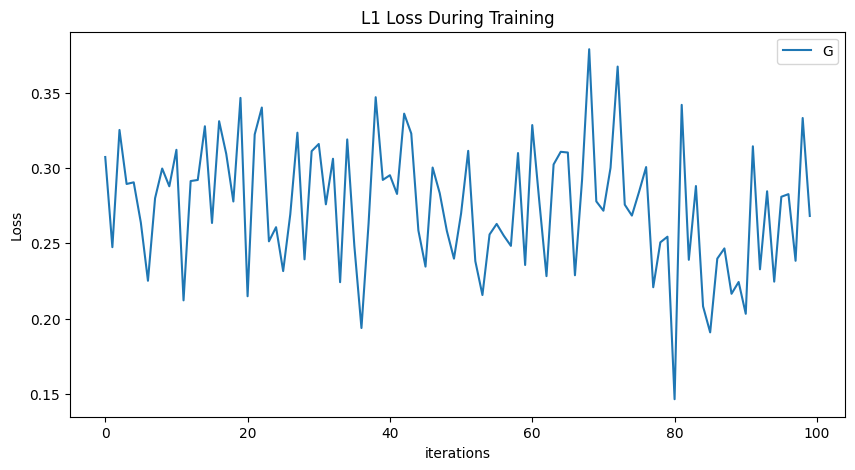

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5))
plt.title("L1 Loss During Training")
plt.plot(G_losses,label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

In [ ]:
torch.save({
            'epoch': num_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'model_seed_{}.pt'.format(torch.random.initial_seed()))

In [ ]:
import cv2

# Load best model
checkpoint = torch.load('model_best.pt')
# checkpoint = torch.load('model_seed_{}.pt'.format(torch.random.initial_seed()))
best_model = idist.auto_model(
    UUNet()
)

best_model.load_state_dict(checkpoint['model_state_dict'])


In [ ]:
root_dir = "dataset"
sony_test_csv_files = ["dataset/Sony_test_list.txt"]

sony_test_dataset = LabeledDataset(root_dir, *sony_test_csv_files, transform=transforms.Compose([
    transforms.ToTensor()
]))
sony_test_dataloader = DataLoader(sony_test_dataset, batch_size=1, num_workers=1)

Creating buffer for 229 images


In [ ]:
import matplotlib.pyplot as plt

with torch.no_grad():
    best_model.eval()
    pretrained_model.eval()
    list_samp = [1, 13, 27, 39, 51, 61, 73]
    o = 0
    for batch in sony_test_dataloader:
    # batch = next(iter(sony_test_dataloader))
        short, long, ratio, cam_model, exposure_ratio, _, _, short_raw = batch
        o += 1
        if o > list_samp[-1]:
            break
        if o not in list_samp:
            continue
        short_ = short
        short = short.to(idist.device())
        long = long.to(idist.device())

        short = pack_sony_raw(short)
        print(torch.mean(short), torch.median(short), torch.min(short), torch.max(short))
        long = long / 65535.0
        short = short * exposure_ratio.float().to(idist.device()).view(-1, 1, 1, 1)
        print(torch.mean(short), torch.median(short), torch.min(short), torch.max(short))
        
        
        pretrained_output, skip_z = pretrained_model(short)
        output = model(pretrained_output, skip_z)
        # output = torch.nn.functional.pixel_shuffle(output, 2)

        output = output[0, :, :, :].to('cpu').numpy()
        output = np.minimum(np.maximum(output, 0), 1)
        gt_full = long[0, :, :, :].to('cpu').numpy()
        raw_input = short_raw[0, :, :, :].to('cpu').numpy() / 65535.0
        scale_full = np.float32(short_raw[0, :, :, :].to('cpu').numpy() / 65535.0)
        scale_full = scale_full * np.mean(gt_full) / np.mean(scale_full) 

        print(np.mean(output[0]), np.median(output[0]), np.min(output[0]), np.max(output[0]))
        print(np.mean(output[1]), np.median(output[1]), np.min(output[1]), np.max(output[1]))
        print(np.mean(output[2]), np.median(output[2]), np.min(output[2]), np.max(output[2]))
        print(np.mean(gt_full[0]), np.median(gt_full[0]), np.min(gt_full[0]), np.max(gt_full[0]))
        print(np.mean(gt_full[1]), np.median(gt_full[1]), np.min(gt_full[1]), np.max(gt_full[1]))
        print(np.mean(gt_full[2]), np.median(gt_full[2]), np.min(gt_full[2]), np.max(gt_full[2]))

        output = np.minimum(np.transpose(output, (1,2,0)) * 255, 255).astype(np.uint8)
        # output = (output-np.min(output))/(np.max(output)-np.min(output))
        gt_full = np.minimum(np.transpose(gt_full, (1,2,0)) * 255, 255).astype(np.uint8)
        raw_input = np.minimum(raw_input * 255, 255).astype(np.uint8)
        scale_full = np.minimum(scale_full * 255, 255).astype(np.uint8)

        color = ('b','g','r')
        plt.figure(figsize=(15,15))
        ax = plt.subplot(4,4,1)
        ax.set_title("Input")
        ax.set_ylim([0, 1e6])
        for i,col in enumerate(color):
            histr = cv2.calcHist([raw_input],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.subplot(4,4,5)
        plt.imshow(raw_input)

        ax = plt.subplot(4,4,2)
        ax.set_title("Histogram Stretching")
        ax.set_ylim([0, 1e6])
        for i,col in enumerate(color):
            histr = cv2.calcHist([scale_full],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.subplot(4,4,6)
        plt.imshow(scale_full)

        ax = plt.subplot(4,4,3)
        ax.set_title("Network Output")
        ax.set_ylim([0, 1e6])
        for i,col in enumerate(color):
            histr = cv2.calcHist([output],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.subplot(4,4,7)
        plt.imshow(output)

        ax = plt.subplot(4,4,4)
        ax.set_title("Ground Truth")
        ax.set_ylim([0, 1e6])
        for i,col in enumerate(color):
            histr = cv2.calcHist([gt_full],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.subplot(4,4,8)
        plt.imshow(gt_full)
        plt.show()

In [ ]:
from ignite.metrics import PSNR, SSIM

def eval_step(engine, batch):
    best_model.eval()
    pretrained_model.eval()
    with torch.no_grad():
        short, long, ratio, cam_model, exposure_ratio, _, _, short_raw = batch

        short = short.to(idist.device())
        long = long.to(idist.device())

        short = pack_sony_raw(short)
        long = long / 65535.0
        short = short * exposure_ratio.float().to(idist.device()).view(-1, 1, 1, 1)   
        
        output = best_model(short)
        output = torch.minimum(torch.maximum(output, torch.Tensor([0]).to(idist.device())), torch.Tensor([1]).to(idist.device()))

        return output, long

evaluator = Engine(eval_step)
psnr = PSNR(data_range=1.0)
psnr.attach(evaluator, 'psnr')
ssim = SSIM(data_range=1.0)
ssim.attach(evaluator, 'ssim')
ProgressBar().attach(evaluator)

In [ ]:
root_dir = "dataset"
sony_val_csv_files = ["dataset/Sony_test_list.txt"]

sony_val_dataset = LabeledDataset(root_dir, *sony_val_csv_files, training=False, transform=transforms.Compose([
    transforms.ToTensor()
]))
sony_val_dataloader = idist.auto_dataloader(sony_val_dataset, batch_size=2, num_workers=8)

Creating buffer for 229 images


2023-06-13 15:53:14,943 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<utils.datasets.Labe': 
	{'batch_size': 2, 'num_workers': 8, 'pin_memory': True}


In [ ]:
state = evaluator.run(sony_val_dataloader)

In [ ]:
print(state.metrics['psnr'])
print(state.metrics['ssim'])